In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

import scipy.sparse as sparse

%matplotlib inline

from implicit.als import AlternatingLeastSquares

In [2]:
raw_data = pd.read_table('usersha1-artmbid-artname-plays.tsv')

/home/truv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [3]:
raw_data.head()

,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
1,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
2,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
3,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
4,00000c289a1829a808ac09c00daf10bc3c4e223b,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,691


In [4]:
raw_data.columns

Index(['00000c289a1829a808ac09c00daf10bc3c4e223b',
       '3bd73256-3905-4f3a-97e2-8b341527f805', 'betty blowtorch', '2137'],
      dtype='object')

In [5]:
raw_data = raw_data.drop(raw_data.columns[1], axis=1)
raw_data.columns = ['user', 'artist', 'plays']

In [6]:
raw_data.head()

,user,artist,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
1,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
2,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
3,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
4,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691


In [7]:
data = raw_data.dropna()

In [8]:
data.loc[[1,2]]

,user,artist,plays
1,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
2,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717


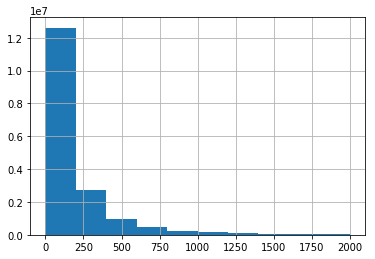

In [9]:
data.iloc[np.where(data.plays < 2000)].plays.hist()

In [10]:
data['user_id'] = data['user'].astype("category").cat.codes
data['artist_id'] = data['artist'].astype("category").cat.codes

/home/truv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/truv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
data.head()

,user,artist,plays,user_id,artist_id
0,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,0,90933
1,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897,0,185367
2,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717,0,106704
3,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706,0,155241
4,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691,0,220128


In [12]:
item_lookup = data[['artist_id', 'artist']].drop_duplicates()
item_lookup['artist_id'] = item_lookup.artist_id.astype(str)

In [13]:
item_lookup.head()

,artist_id,artist
0,90933,die Ärzte
1,185367,melissa etheridge
2,106704,elvenking
3,155241,juliette & the licks
4,220128,red hot chili peppers


In [14]:
artist_id_name = {}

for index, row in tqdm_notebook(item_lookup.iterrows()):
    artist_id_name[row.artist_id] = row.artist

In [15]:
data = data.drop(['user', 'artist'], axis=1)

In [16]:
data.head()

,plays,user_id,artist_id
0,1099,0,90933
1,897,0,185367
2,717,0,106704
3,706,0,155241
4,691,0,220128


In [17]:
data = data.loc[data.plays != 0]

In [18]:
data.head()

,plays,user_id,artist_id
0,1099,0,90933
1,897,0,185367
2,717,0,106704
3,706,0,155241
4,691,0,220128


In [19]:
users = list(np.sort(data.user_id.unique()))
artists = list(np.sort(data.artist_id.unique()))
plays = list(data.plays)

In [20]:
users[:5]

[0, 1, 2, 3, 4]

In [21]:
artists[:5]

[0, 1, 2, 3, 4]

In [22]:
plays[:5]

[1099, 897, 717, 706, 691]

In [23]:
len(users)

358868

In [24]:
len(artists)

292363

In [25]:
rows = data.user_id.astype(int)
cols = data.artist_id.astype(int)

In [26]:
data_sparse = sparse.csr_matrix((plays, (cols, rows)), shape=(len(artists), len(users)))

In [27]:
model = AlternatingLeastSquares(factors=50)
model.fit(data_sparse)

100%|██████████| 15.0/15 [02:09<00:00,  9.08s/it]


In [28]:
userid = 0

user_items = data_sparse.T.tocsr()
recommendations = model.recommend(userid, user_items)

In [29]:
recommendations

[(255208, 1.4354894),
 (161833, 1.386636),
 (107103, 1.306504),
 (12523, 1.2394924),
 (90690, 1.1967964),
 (116811, 1.1831782),
 (249542, 1.1823306),
 (264730, 1.1821377),
 (108566, 1.1786919),
 (165921, 1.1732564)]

In [30]:
for r in recommendations:
    print(artist_id_name[str(r[0])])

the dresden dolls
kittie
emilie autumn
after forever
die happy
flyleaf
tarja turunen
the white stripes
epica
lacuna coil


In [31]:
itemid = 107209
related = model.similar_items(itemid)

In [32]:
related

[(107209, 0.10995704),
 (157178, 0.09606841),
 (187011, 0.09417115),
 (247942, 0.09345406),
 (171169, 0.093335286),
 (3845, 0.09315104),
 (128172, 0.0930436),
 (48904, 0.09303317),
 (260378, 0.09276162),
 (218091, 0.091624394)]

In [33]:
for a in related:
    print(artist_id_name[str(a[0])])

eminem
kanye west
michael jackson
system of a down
linkin park
50 cent
green day
black eyed peas
the offspring
rage against the machine


In [37]:
artist_id_name['234786']

'sick on the bus'

# HomeWork

tags = pd.read_csv('tags.dat',encoding='cp1251', sep='\t')

In [4]:
user_contacts = pd.read_csv('user_contacts.dat',encoding='cp1251', sep='\t')

In [5]:
user_contacts_timestamps = pd.read_csv('user_contacts-timestamps.dat',encoding='cp1251', sep='\t')

In [6]:
user_taggedbookmarks = pd.read_csv('user_taggedbookmarks.dat',encoding='cp1251', sep='\t')

In [7]:
user_taggedbookmarks_timestamps = pd.read_csv('user_taggedbookmarks-timestamps.dat',encoding='cp1251', sep='\t')

In [49]:
user_contacts_timestamps.head()

,userID,contactID,timestamp
0,8,28371,1286151259000
1,8,40306,1286101989000
2,8,85279,1285981848000
3,8,91764,1286225027000
4,8,97723,1286846913000


In [50]:
user_contacts.head()

,userID,contactID,date_day,date_month,date_year,date_hour,date_minute,date_second
0,8,28371,4,10,2010,2,14,19
1,8,40306,3,10,2010,12,33,9
2,8,85279,2,10,2010,3,10,48
3,8,91764,4,10,2010,22,43,47
4,8,97723,12,10,2010,3,28,33


In [51]:
user_taggedbookmarks.head()

,userID,bookmarkID,tagID,day,month,year,hour,minute,second
0,8,1,1,8,11,2010,23,29,22
1,8,2,1,8,11,2010,23,25,59
2,8,7,1,8,11,2010,18,55,1
3,8,7,6,8,11,2010,18,55,1
4,8,7,7,8,11,2010,18,55,1


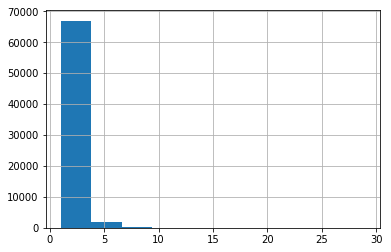

In [60]:
user_taggedbookmarks.groupby('bookmarkID')['userID'].nunique().hist();

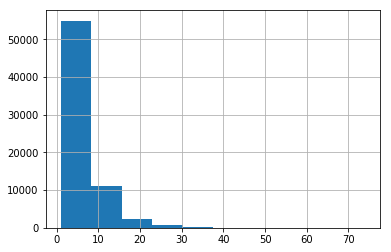

In [59]:
user_taggedbookmarks.groupby('bookmarkID')['tagID'].nunique().hist();

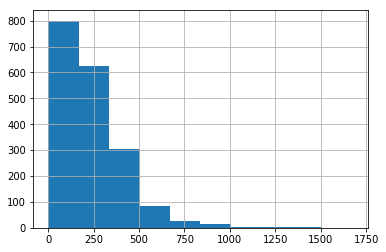

In [63]:
user_taggedbookmarks.groupby('userID')['tagID'].size().hist();

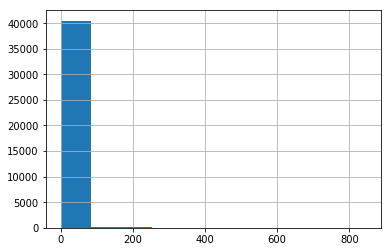

In [73]:
user_taggedbookmarks.groupby('tagID')['userID'].nunique().hist();

In [8]:
df = user_taggedbookmarks[['userID','bookmarkID','tagID']]

In [9]:
df.isnull().sum()

userID        0
bookmarkID    0
tagID         0
dtype: int64

In [10]:
df[df.bookmarkID == 0]

,userID,bookmarkID,tagID


In [12]:
users = list(np.sort(df.userID.unique()))
artists = list(np.sort(df.bookmarkID.unique()))
vec = []
for user in users:
    bks = np.zeros(max(artists))

    vals = np.unique(df[df.userID == user].bookmarkID.values)

    for v in vals:
        bks[v-1] = 1
    vec.append(bks)

In [13]:
from numpy import array


In [14]:
data_sparse = sparse.csr_matrix(array(vec[:550]))

In [15]:
model = AlternatingLeastSquares(factors=50)
model.fit(data_sparse)

100%|██████████| 15.0/15 [00:01<00:00,  8.57it/s]


In [16]:
userid = 8

user_items = data_sparse.T.tocsr()
recommendations = model.recommend(userid, user_items)

In [17]:
recommendations

[(300, 0.075004056),
 (24, 0.07021195),
 (282, 0.070081),
 (243, 0.06995992),
 (253, 0.06885314),
 (342, 0.063120596),
 (37, 0.05601996),
 (355, 0.051763188),
 (240, 0.050506894),
 (214, 0.046738513)]

In [42]:
for x in recommendations:
    print('Recommended bookmar ID ', artists[x[0]])
    t  = np.unique(df[df.bookmarkID == artists[x[0]]].tagID.values)
    for tag in t:
        print('Related tag for {} is {}'.format(artists[x[0]],tags[tags.id == tag].values[0][1]))

Recommended bookmar ID  432
Related tag for 432 is twitter
Related tag for 432 is facebook
Related tag for 432 is social
Related tag for 432 is media
Related tag for 432 is tips
Related tag for 432 is people
Related tag for 432 is blogging
Related tag for 432 is 10
Related tag for 432 is advice
Related tag for 432 is manners
Related tag for 432 is etiquette
Related tag for 432 is employment
Related tag for 432 is creation
Recommended bookmar ID  36
Related tag for 36 is collection_development
Related tag for 36 is virtual_library
Related tag for 36 is paid_subscription
Related tag for 36 is blogs_library
Related tag for 36 is design
Related tag for 36 is pakage
Related tag for 36 is designs
Related tag for 36 is jobs
Related tag for 36 is southafrica
Related tag for 36 is phpmyadmin
Related tag for 36 is sh
Related tag for 36 is alg
Recommended bookmar ID  409
Related tag for 409 is learning
Related tag for 409 is wikis
Related tag for 409 is socialpeoplerelationshipcriticism
Related t